# COVID-19 Data Analysis and Trend Prediction

**Support Vector Regression** to predict COVID-19 Trends for Cases and Deaths for the Ten Worst Affected Countries.

Data is pulled directly from the [WHO web site](https://who.org) and reconfigured so it can be fed into a Machine Learning model that predicts cases and deaths for future deaths based on past data. 


We use **SVR** as it is fast(er) and reliable and used by many financial institutions for stock market *forecasting.*

In [48]:
### Import Dependancies

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

import random
import math
import time

from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')

# Enable files to be sent directly to google drive.
from google.colab import files
from google.colab import drive
drive.mount('/Drive')

from scipy.fft import fft, ifft

Drive already mounted at /Drive; to attempt to forcibly remount, call drive.mount("/Drive", force_remount=True).


# **Import World Health Organization Data**
The data is imported directly from the WHO website.  This data is updated by WHO daily. 

In [49]:
whoURL = 'https://covid19.who.int/WHO-COVID-19-global-data.csv'
who_data = pd.read_csv(whoURL)

In [50]:
who_data.tail(5)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
29711,2020-07-17,ZW,Zimbabwe,AFRO,273,1362,3,23
29712,2020-07-18,ZW,Zimbabwe,AFRO,58,1420,1,24
29713,2020-07-19,ZW,Zimbabwe,AFRO,58,1478,1,25
29714,2020-07-20,ZW,Zimbabwe,AFRO,133,1611,0,25
29715,2020-07-21,ZW,Zimbabwe,AFRO,102,1713,1,26


In [51]:
# Drop rows that have missing values
print(who_data.shape)
who_data.dropna(inplace=True)
print(who_data.shape)

(29716, 8)
(29586, 8)


In [52]:
# reconfigure the data so we have just deaths
cumulative_deaths = who_data.filter(['Date_reported', ' Cumulative_deaths'], axis = 1)
cumulative_deaths = cumulative_deaths.groupby('Date_reported', as_index=False).sum()
cumulative_deaths.head(3)

,Date_reported,Cumulative_deaths
0,2020-01-11,1
1,2020-01-12,1
2,2020-01-13,1


In [53]:
# reconfigure the data so we have just cases
cumulative_cases = who_data.filter(['Date_reported', ' Cumulative_cases'], axis = 1)
cumulative_cases = cumulative_cases.groupby('Date_reported', as_index=False).sum()
cumulative_cases.tail(3)

,Date_reported,Cumulative_cases
190,2020-07-19,14117930
191,2020-07-20,14347666
192,2020-07-21,14561206


In [54]:
# store the earliest and latest dates available
earliest_reported = who_data['Date_reported'].min()
earliest_reported
last_updated = who_data['Date_reported'].max()
last_updated


'2020-07-21'

In [57]:
dates = cumulative_cases['Date_reported']
dates.tail(3)

190    2020-07-19
191    2020-07-20
192    2020-07-21
Name: Date_reported, dtype: object

In [58]:
world_cases = np.array(cumulative_cases[' Cumulative_cases'])
world_cases

array([      41,       41,       42,       43,       43,       43,
             48,       65,      125,      203,      296,      450,
            583,      854,     1323,     2021,     2806,     4595,
           6076,     7836,     9846,    11961,    14559,    17391,
          20649,    24563,    28284,    31486,    34899,    37568,
          40623,    43109,    45174,    60387,    64455,    67187,
          69277,    71438,    73431,    75287,    75773,    76817,
          77926,    78942,    79566,    80392,    81316,    82685,
          84133,    85959,    87850,    90131,    92463,    94663,
          97440,   101240,   105166,   108904,   112951,   117439,
         123964,   130483,   140126,   151636,   163489,   175280,
         190104,   208533,   232509,   265401,   288849,   298185,
         331907,   391864,   422395,   478118,   519722,   582513,
         644250,   701942,   760029,   833723,   907004,   982209,
        1062266,  1142094,  1219079,  1288420,  1362610,  1445

In [59]:
total_deaths = np.array(cumulative_deaths[' Cumulative_deaths'])
total_deaths

array([     1,      1,      1,      1,      1,      1,      2,      2,
            3,      4,      6,      9,     17,     25,     41,     56,
           80,    106,    132,    170,    213,    259,    305,    362,
          426,    492,    565,    638,    724,    813,    910,   1018,
         1115,   1371,   1384,   1528,   1670,   1776,   1874,   2012,
         2130,   2250,   2363,   2464,   2628,   2711,   2772,   2815,
         2874,   2942,   2987,   3074,   3154,   3245,   3346,   3459,
         3554,   3800,   4005,   4288,   4647,   5005,   5492,   5926,
         6659,   7399,   8233,   9307,  10528,  12086,  13849,  14660,
        16709,  18989,  21380,  24247,  26945,  30330,  33771,  37172,
        40842,  45088,  50019,  54899,  61545,  67344,  72347,  77732,
        84611,  90963,  98408, 105301, 111509, 117128, 122584, 128762,
       136626, 149030, 155606, 162436, 167530, 172957, 179681, 186310,
       192604, 198451, 204823, 209614, 213648, 218898, 224785, 231088,
      

In [60]:
days_since_start = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases     = np.array(world_cases).reshape(-1, 1)
total_deaths    = np.array(total_deaths).reshape(-1, 1)

# Future Forecasting



In [61]:
days_in_future  = 30  # WE WILL GO 30 DAYS INTO THE FUTURE
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates  = future_forecast[:-30]

In [63]:
start = earliest_reported
start_date = datetime.datetime.strptime(start, '%Y-%m-%d')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime( '%m/%d/%Y'))

# Machine Learning

**Support Vector Machines** are commonly used for classification.  However, we can use **Support Vector Regression (SVR) ** for prediction and forecasting in Machine Learning.  SVR is used to predict real values rather than a particular class. 

In [37]:
# Have a function to go through each country one by one and create a new .csvfile. 

def one_country(country_name, feature):
    one_country = who_data[who_data[' Country']==country_name]
    print("Processing: ", country_name.upper())
    #print(one_country)
    
    # reconfigure the data so we have just features we need. 
    X = one_country.filter(['Date_reported', feature], axis = 1)
    X = X.groupby('Date_reported', as_index=False).sum()
    #print(X.tail(3))
    
    y = np.array(X[feature])
    
    one_cases  = np.array(y).reshape(-1, 1)

    dates = X['Date_reported']

    days_since_start= np.array([i for i in range(len(dates))]).reshape(-1, 1)
   
    days_in_future  = 30  # WE WILL GO 30 DAYS INTO THE FUTURE
    future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
    
    adjusted_dates  = future_forecast[:-30]
    
    ### print(len(future_forecast))
    ### Split the data
    X_train_confirmed, X_test_confirmed,y_train_confirmed, y_test_confirmed = train_test_split(days_since_start, one_cases, test_size=0.35, shuffle=True)


    #building SVM Regression Model
    kernel = ['poly', 'sigmoid', 'rbf']
    c = [0.01, 0.1, 1 ]
    gamma = [0.01, 0.1]
    epsilon = [0.01, 0.1]
    shrinking = [True, False]
    svm_grid = {'kernel':kernel, 'C':c, 'gamma':gamma, 'epsilon':epsilon, 'shrinking':shrinking}

    svm        = SVR() #initialize the model to Support Vector Regression

    ## Perform Hyper tuning 
    svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv = 3, n_jobs=-1, n_iter=10, return_train_score=True, verbose =1)

    svm_search.fit(X_train_confirmed, y_train_confirmed.ravel())  
    
    
    svm_search.best_params_
    svm_confirmed = svm_search.best_estimator_
    svm_pred      = svm_confirmed.predict(future_forecast)
    
    # Check against testing data

    svm_test_pred = svm_confirmed.predict(X_test_confirmed)
    plt.figure()
    plt.title(country_name.upper() + ': ' + feature + ' Test the model (y_test) (blue), Predicted (red)')
    plt.plot(svm_test_pred, color='RED') #Predicted.
    plt.plot(y_test_confirmed)   #Actual
    plt.xlabel('Random Sample')
    plt.ylabel('test/predicted') 


    images_dir = '/Drive/My Drive/Colab Notebooks/COVID19/'
    plt.savefig(f"{images_dir}/{country}_{feature}_test.png")
    
    plt.figure(figsize=(20, 12))
    plt.title(country_name.upper() + ": " + feature + ' (blue), Predicted (red)')
    plt.plot(adjusted_dates, one_cases)
    _ = plt.plot(future_forecast, svm_pred, linestyle='dashed', color='red') 
    plt.xlabel('Days Since Reporting began')
    plt.ylabel(f'test/predicted {feature}')

    score = svm_confirmed.score(X_train_confirmed, y_train_confirmed)
    print('Country: ', country, " training score: ", score)

    score = svm_confirmed.score(X_test_confirmed, y_test_confirmed)
    print('Country: ',country, " test score: ", score)
 

    images_dir = '/Drive/My Drive/Colab Notebooks/COVID19/'
    plt.savefig(f"{images_dir}/{country}_{feature}_pred.png")


    return(svm_pred)

Create a list of the **worst affected countries**


In [64]:
worst_affected_countries = ['Brazil', 'Chile', 'India', 'Iran (Islamic Republic of)', 'Mexico', 'Peru', 'Russian Federation', 'South Africa', 'The United Kingdom','United States of America'] 
                            

# Predicting Trends
Loop through each country making predictions, saving to CSV and PNG and outputting accuracy


Brazil
Processing:  BRAZIL
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


Country:  Brazil  training score:  0.990862496195788
Country:  Brazil  test score:  0.9948781302927522
Processing:  BRAZIL
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   46.3s finished


Country:  Brazil  training score:  0.9896033336259056
Country:  Brazil  test score:  0.9841023050755183
Chile
Processing:  CHILE
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.8s finished


Country:  Chile  training score:  0.9695758223708217
Country:  Chile  test score:  0.977809768886876
Processing:  CHILE
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.1min remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


Country:  Chile  training score:  0.9634665046040556
Country:  Chile  test score:  0.9689877303241751
India
Processing:  INDIA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


Country:  India  training score:  0.9322890449570427
Country:  India  test score:  0.8989498276296222
Processing:  INDIA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.4s finished


Country:  India  training score:  0.9663996653340942
Country:  India  test score:  0.9095525814330885
Iran (Islamic Republic of)
Processing:  IRAN (ISLAMIC REPUBLIC OF)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


Country:  Iran (Islamic Republic of)  training score:  0.8866681404424069
Country:  Iran (Islamic Republic of)  test score:  0.8942790004721438
Processing:  IRAN (ISLAMIC REPUBLIC OF)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.3min finished


Country:  Iran (Islamic Republic of)  training score:  0.7980078917418052
Country:  Iran (Islamic Republic of)  test score:  0.7835499927881807
Mexico
Processing:  MEXICO
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


Country:  Mexico  training score:  0.9981987562751052
Country:  Mexico  test score:  0.9974098353802351
Processing:  MEXICO
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


Country:  Mexico  training score:  0.9943622971025069
Country:  Mexico  test score:  0.9946027357645894
Peru
Processing:  PERU
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Peru  training score:  0.9478108743070788
Country:  Peru  test score:  0.9371522656633409
Processing:  PERU
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    6.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.2s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Peru  training score:  0.9878765951881411
Country:  Peru  test score:  0.983256277874093
Russian Federation
Processing:  RUSSIAN FEDERATION
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Russian Federation  training score:  0.9628639480015834
Country:  Russian Federation  test score:  0.9693398281902201
Processing:  RUSSIAN FEDERATION
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.3min finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  Russian Federation  training score:  0.9890252197908246
Country:  Russian Federation  test score:  0.9873582248077237
South Africa
Processing:  SOUTH AFRICA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  South Africa  training score:  0.8434284236635738
Country:  South Africa  test score:  0.8755773063249068
Processing:  SOUTH AFRICA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  South Africa  training score:  0.9660307969586718
Country:  South Africa  test score:  0.9587959243433409
The United Kingdom
Processing:  THE UNITED KINGDOM
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  The United Kingdom  training score:  0.7073476173246664
Country:  The United Kingdom  test score:  0.6600858941846874
Processing:  THE UNITED KINGDOM
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  The United Kingdom  training score:  0.6858822054073428
Country:  The United Kingdom  test score:  0.6702016689212468
United States of America
Processing:  UNITED STATES OF AMERICA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  United States of America  training score:  0.9601246435132482
Country:  United States of America  test score:  0.9698728880231633
Processing:  UNITED STATES OF AMERICA
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   10.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.2s finished
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Country:  United States of America  training score:  0.8506038407871698
Country:  United States of America  test score:  0.8693260484101415


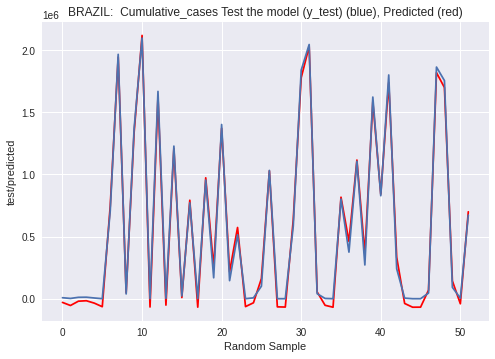

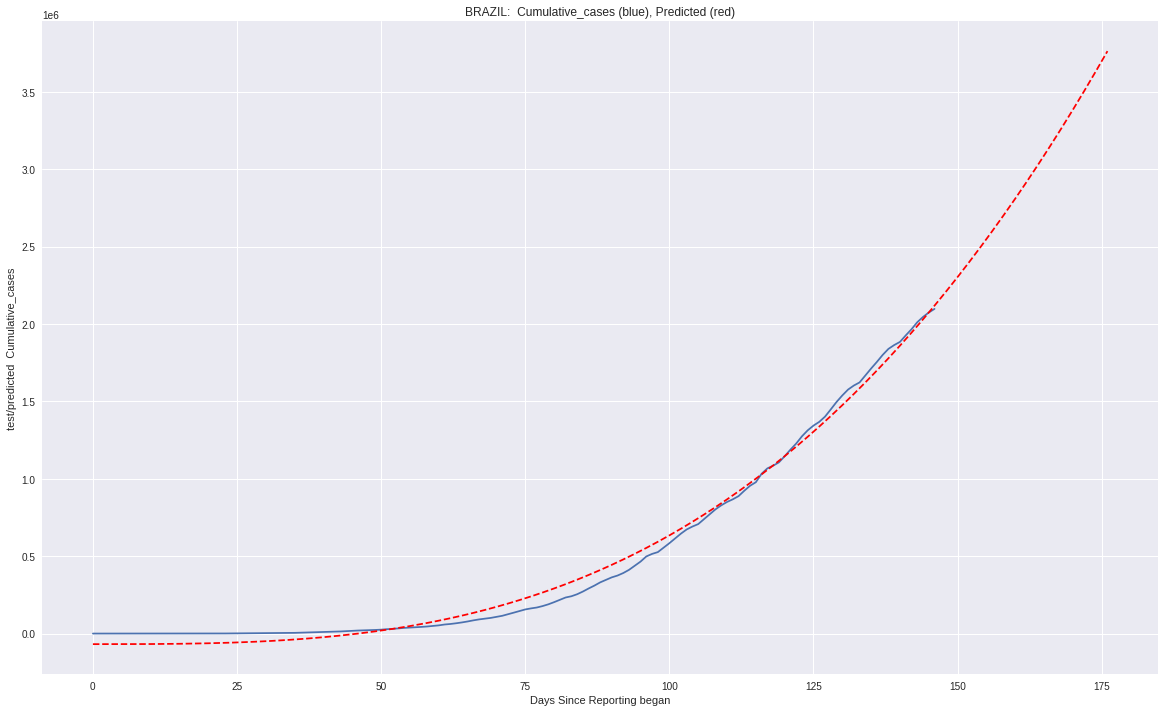

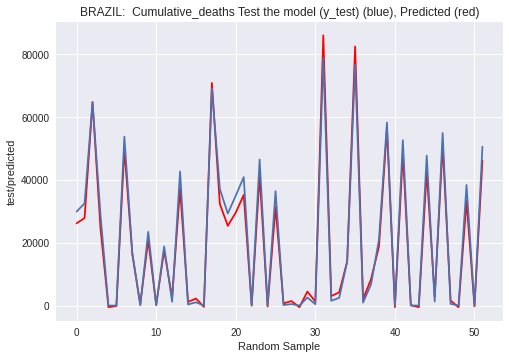

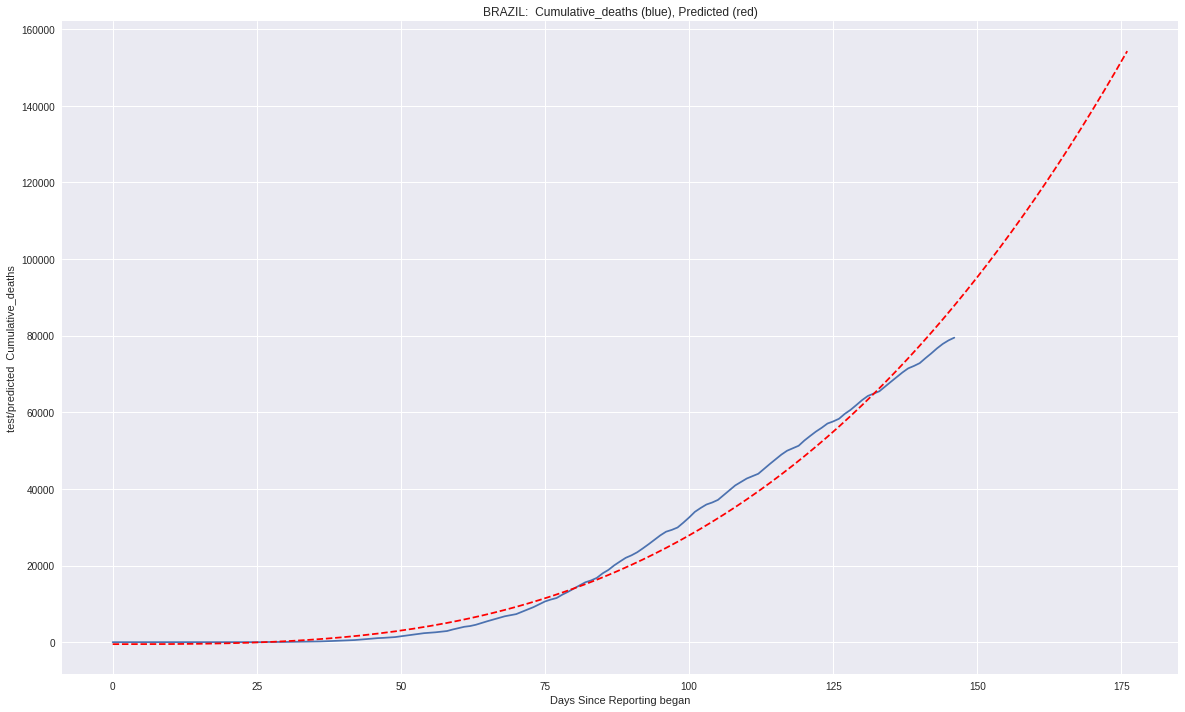

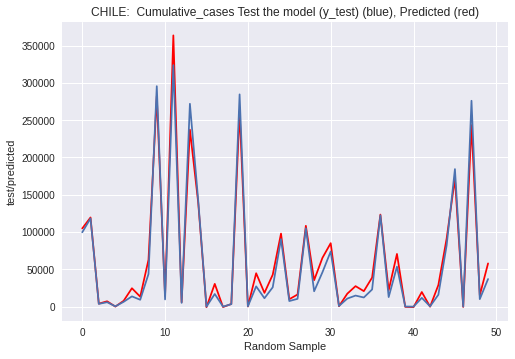

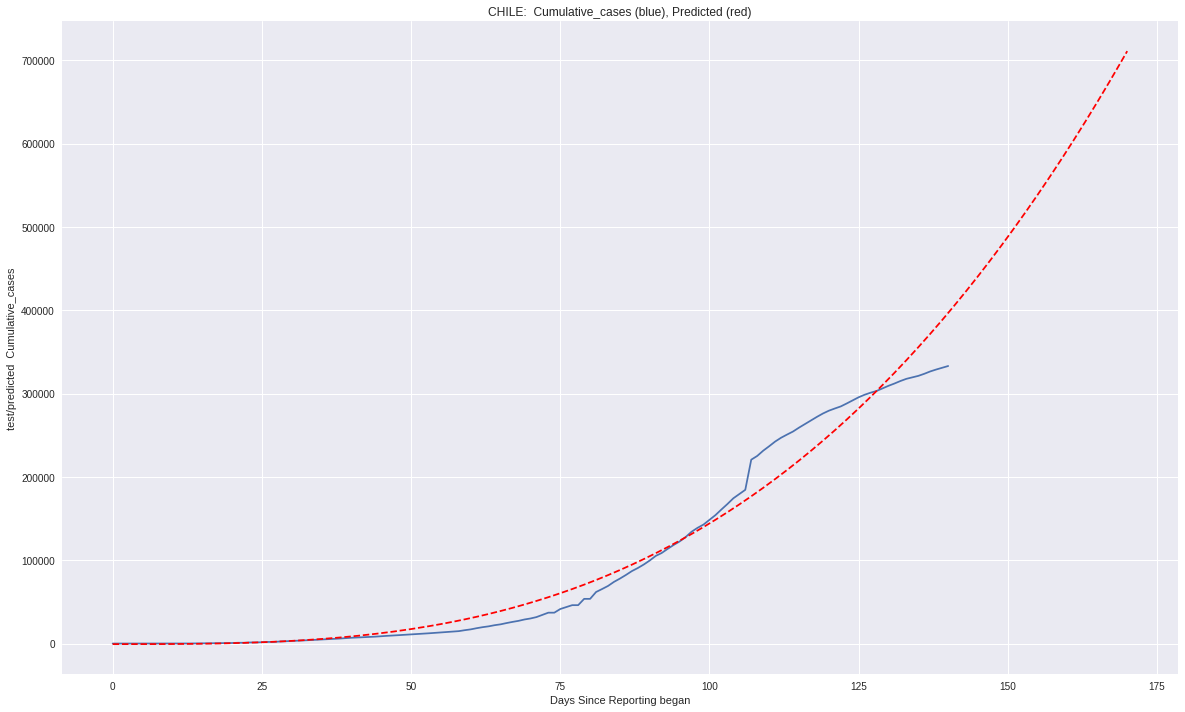

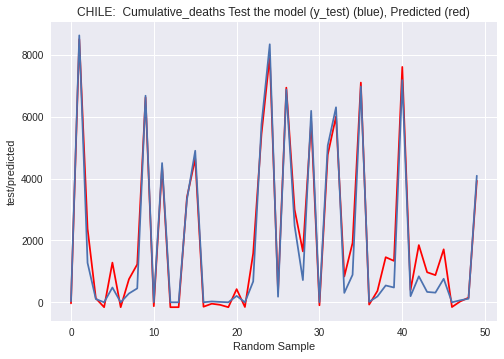

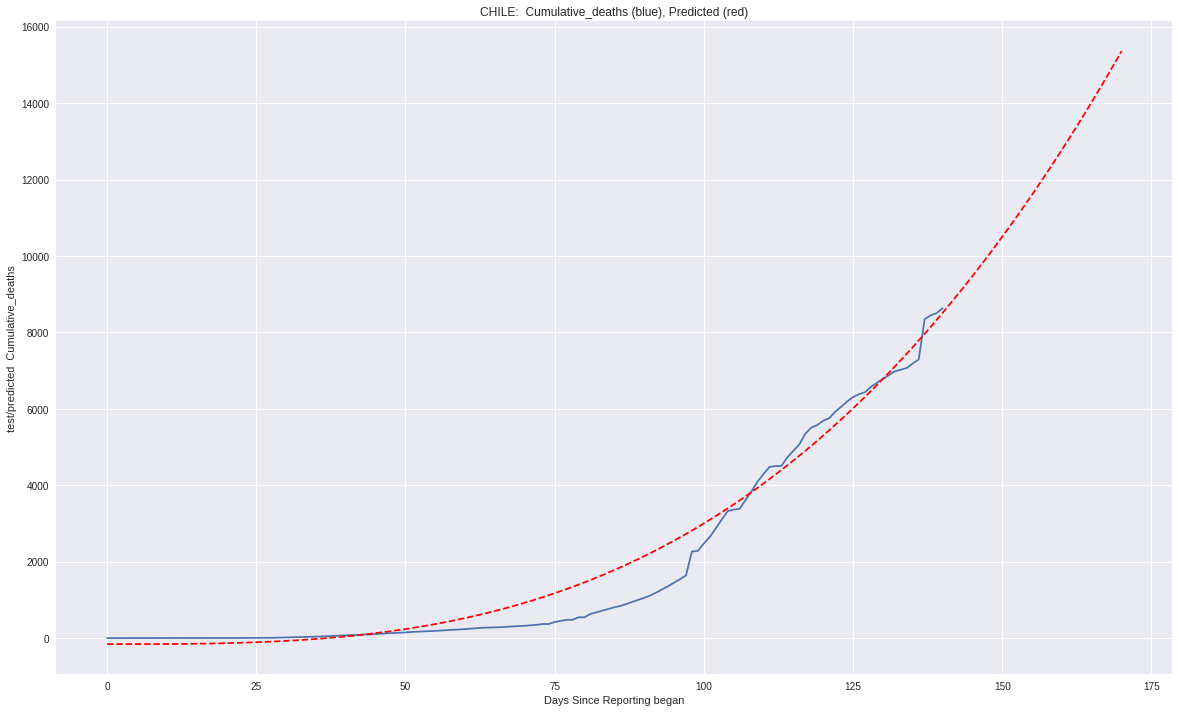

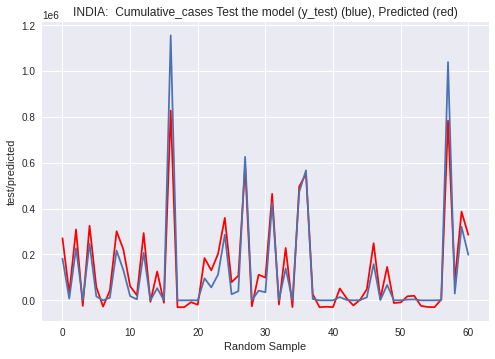

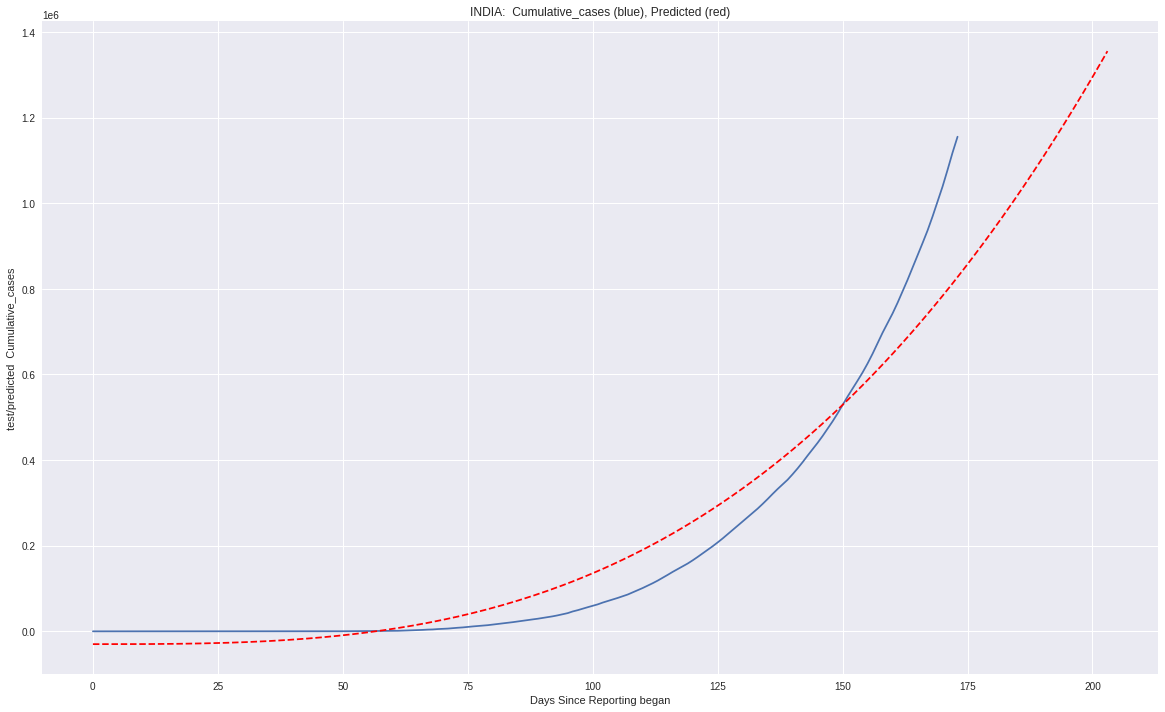

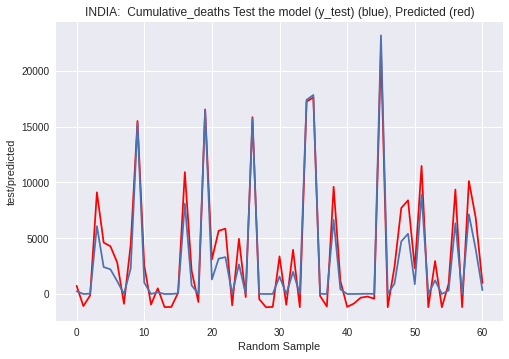

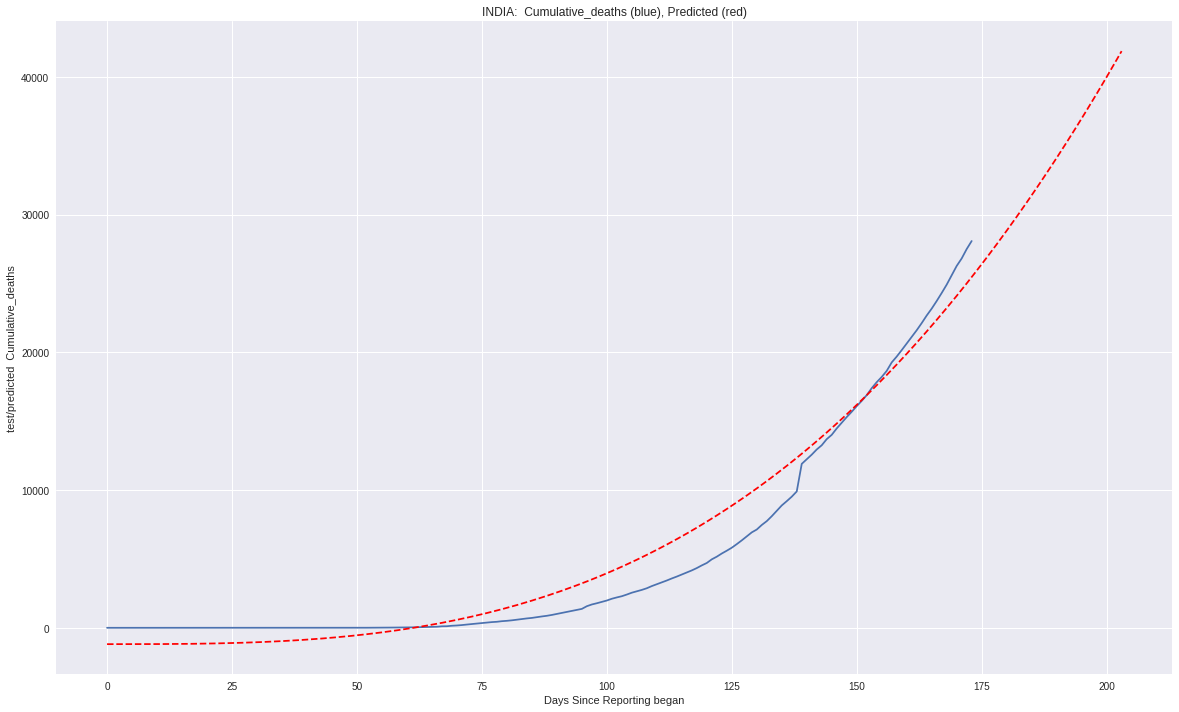

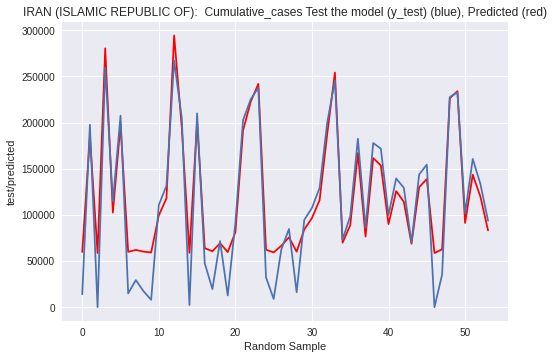

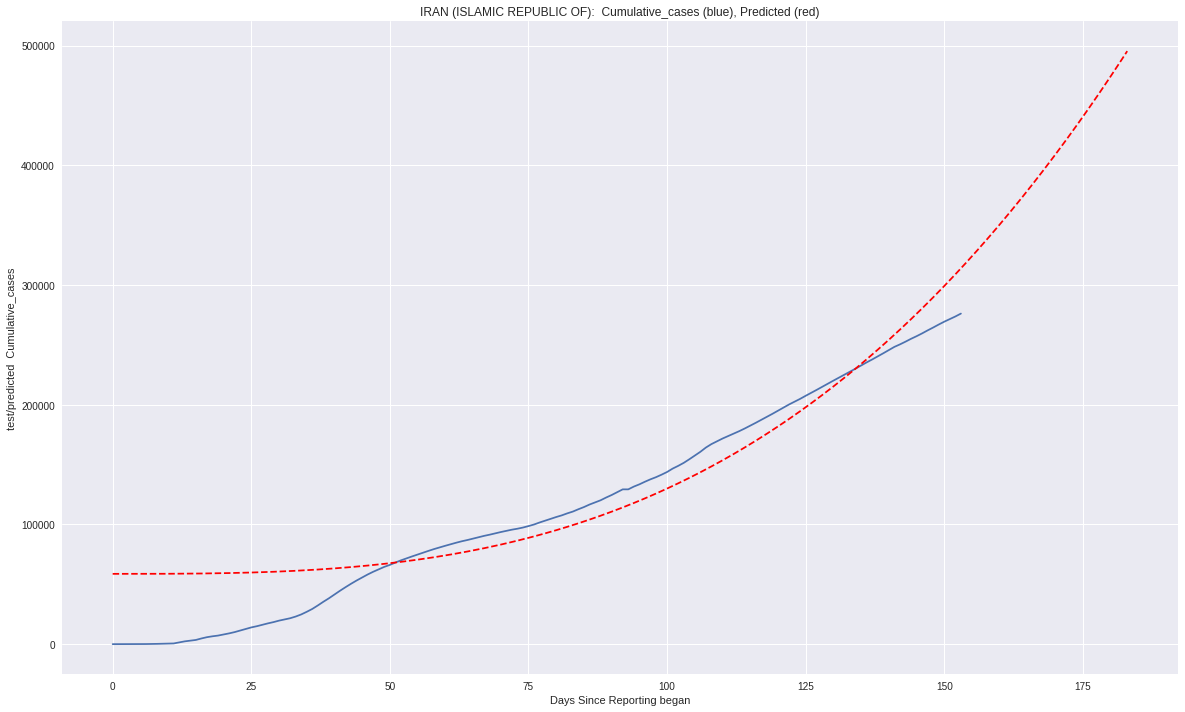

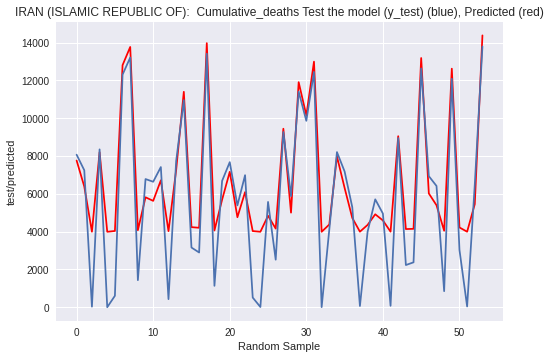

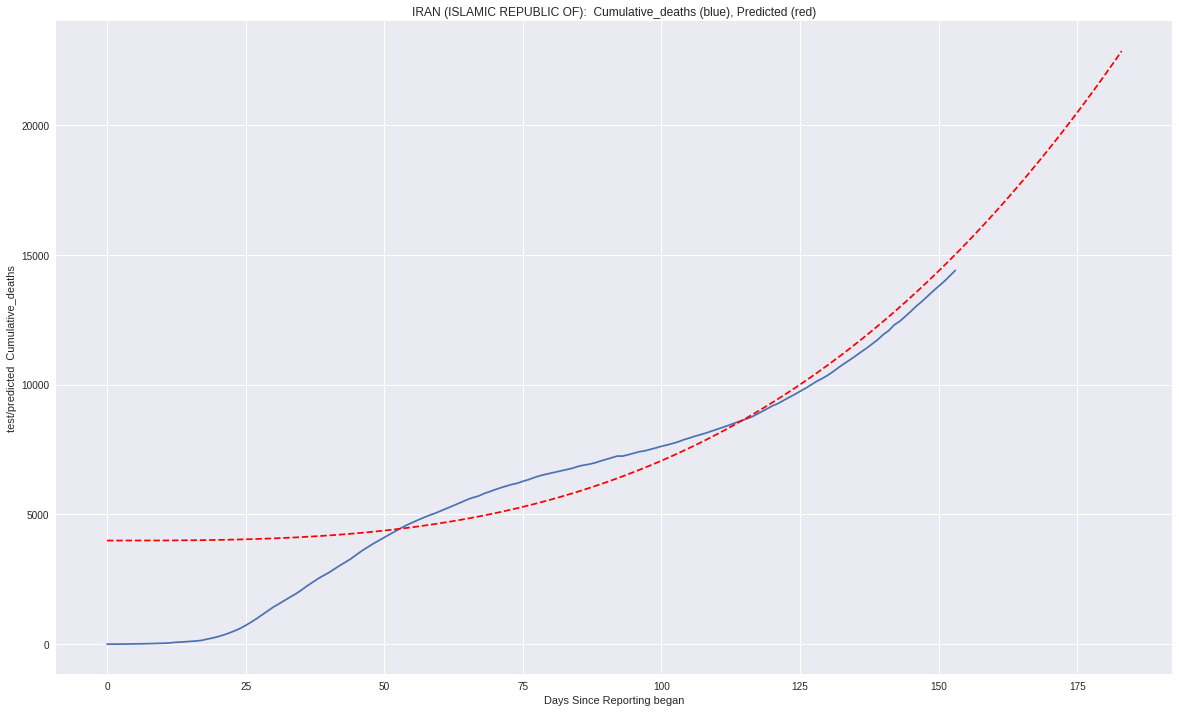

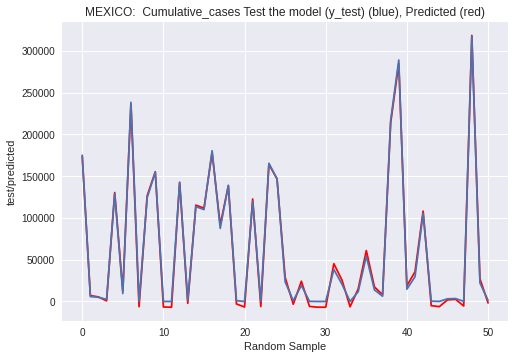

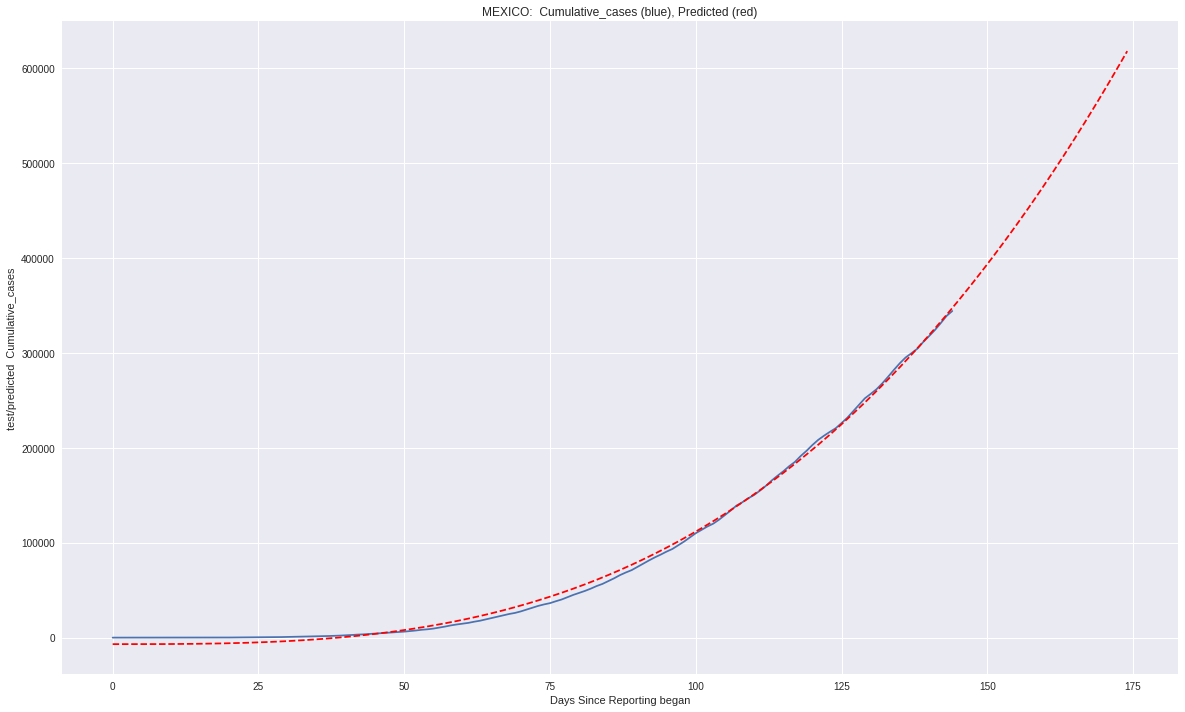

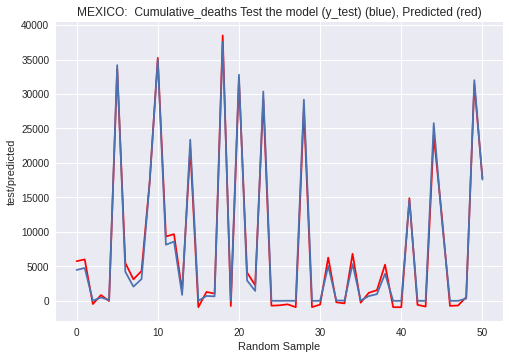

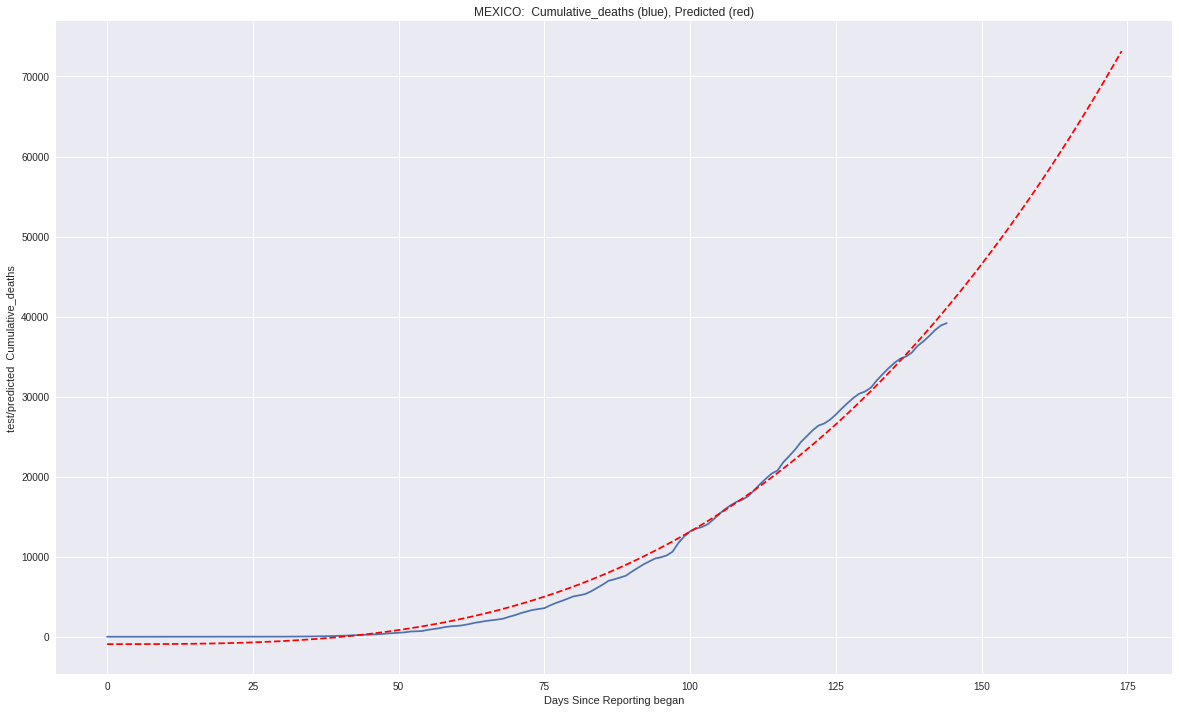

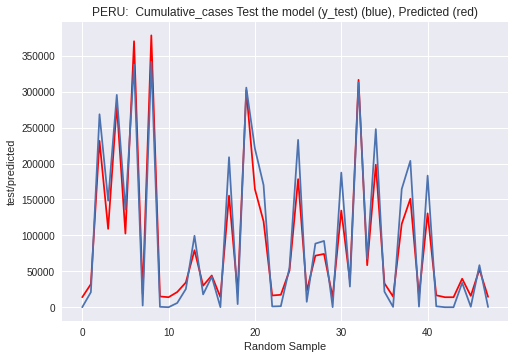

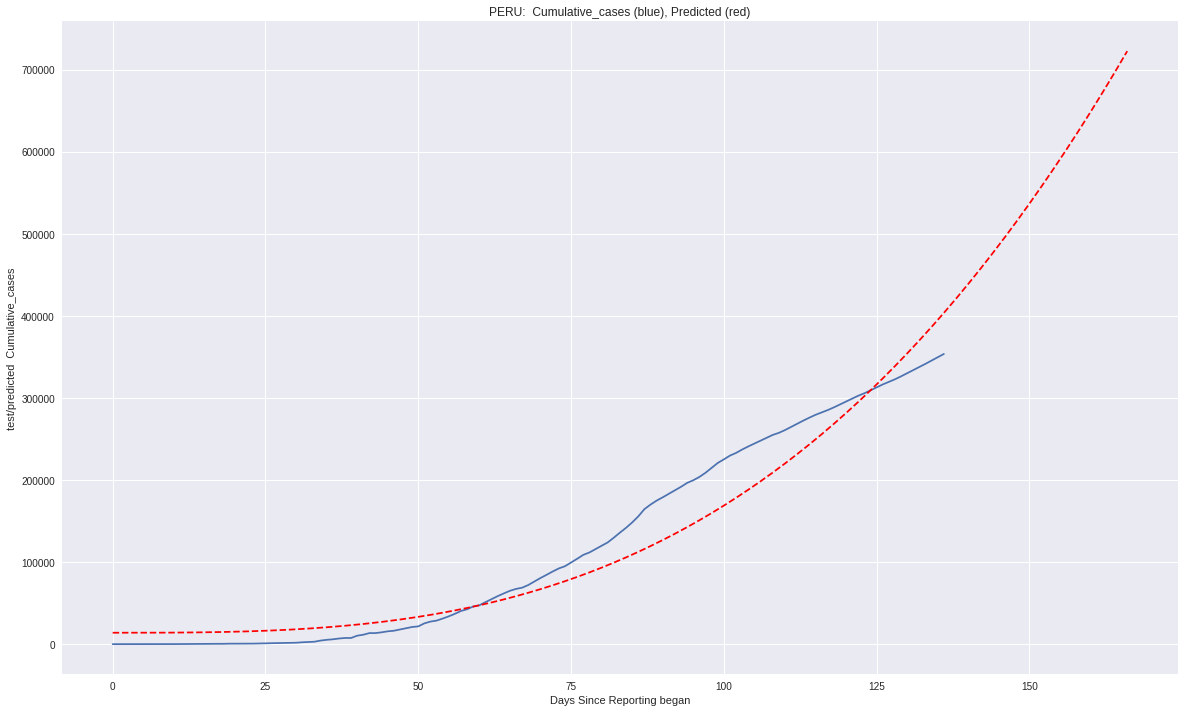

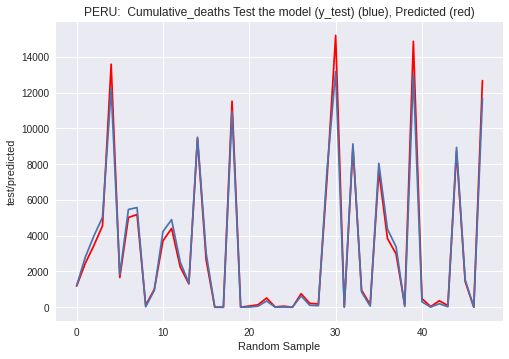

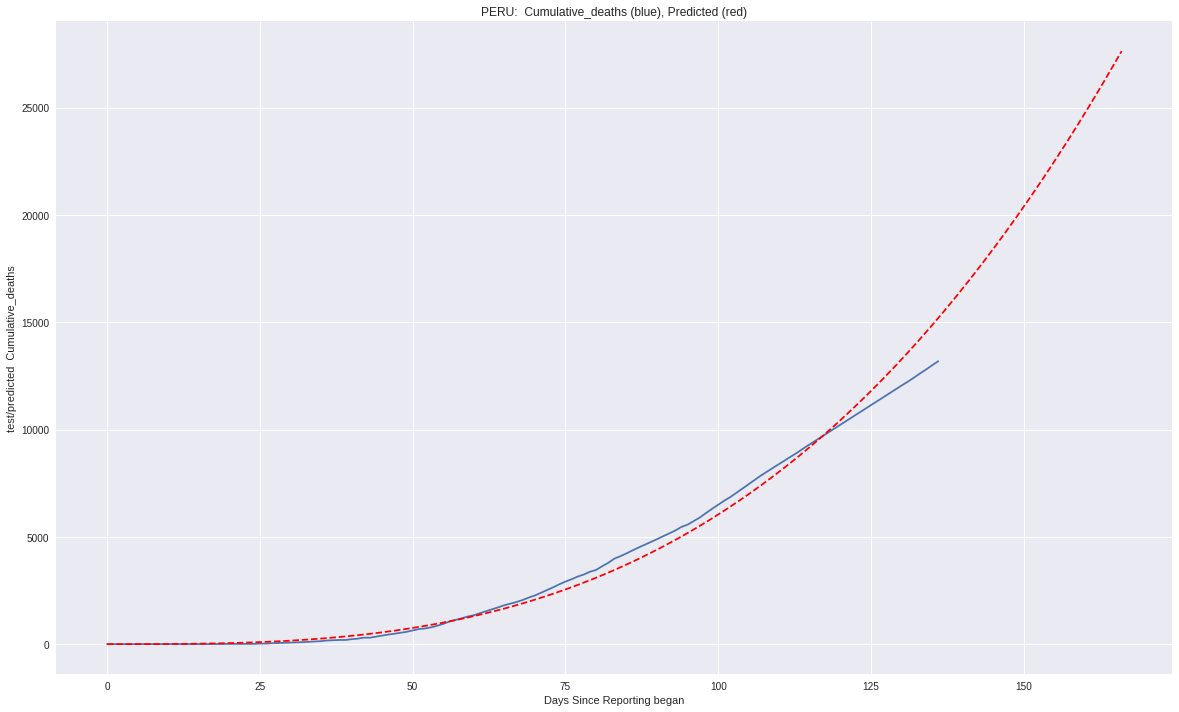

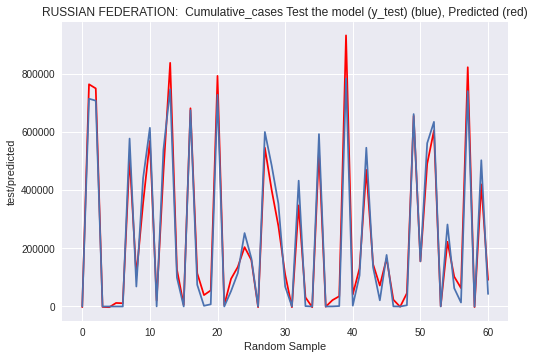

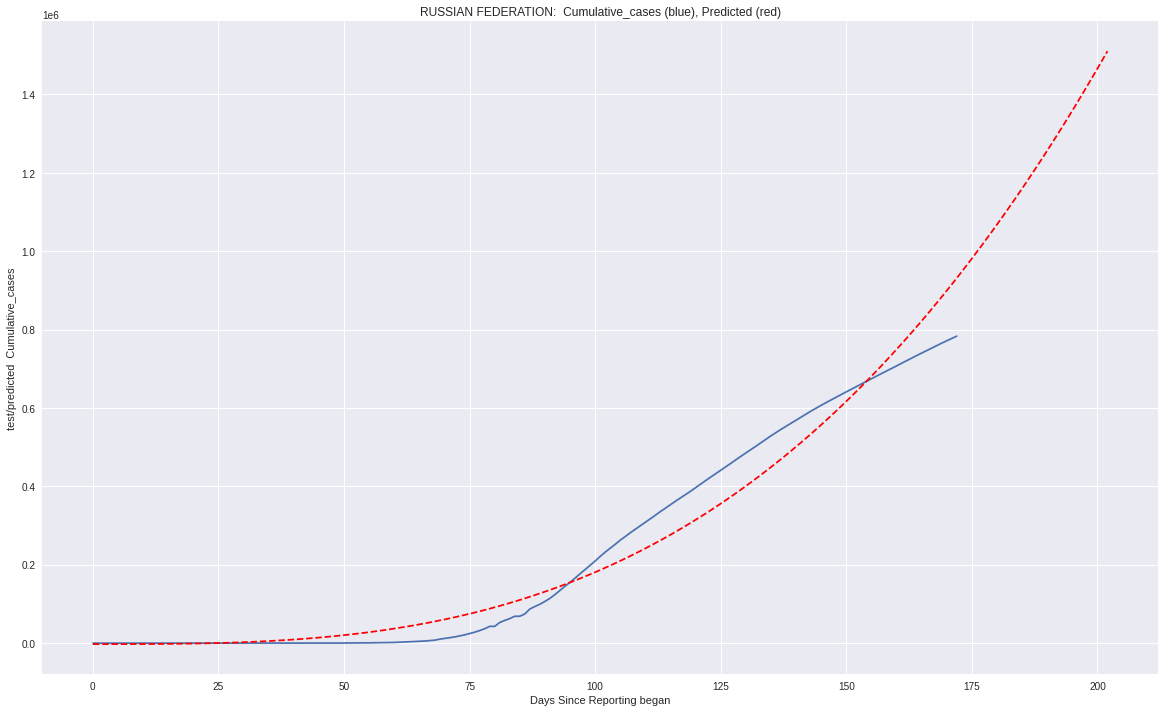

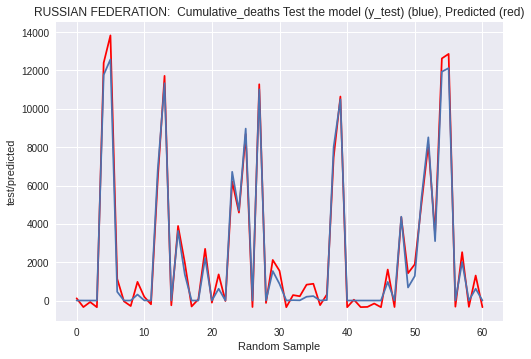

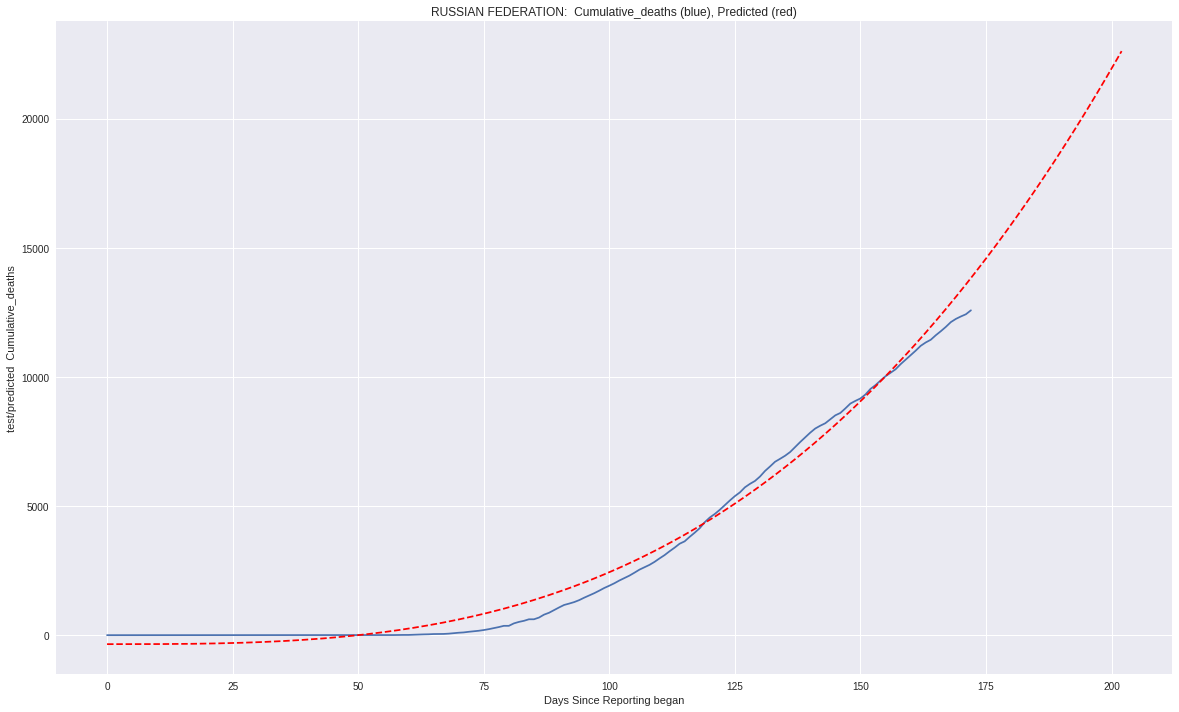

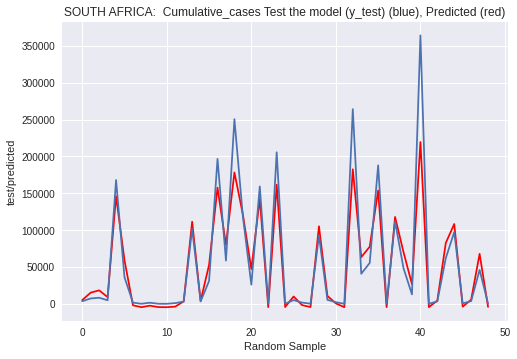

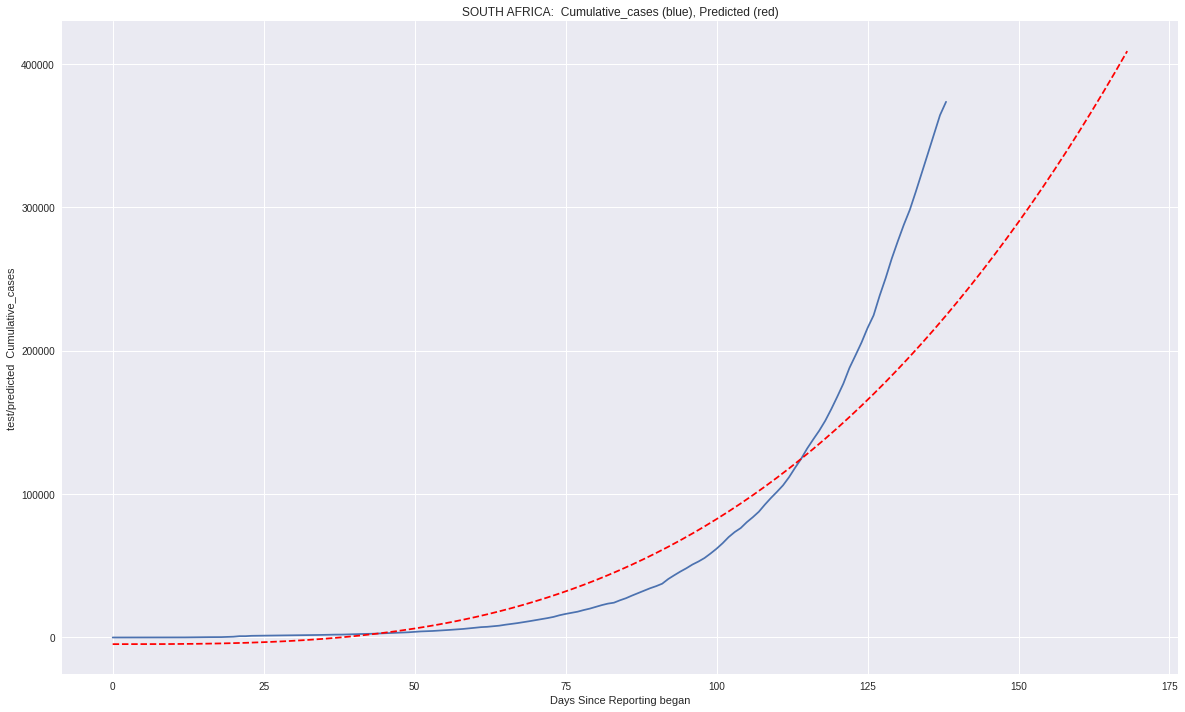

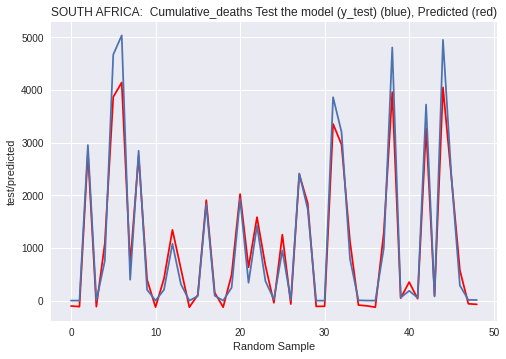

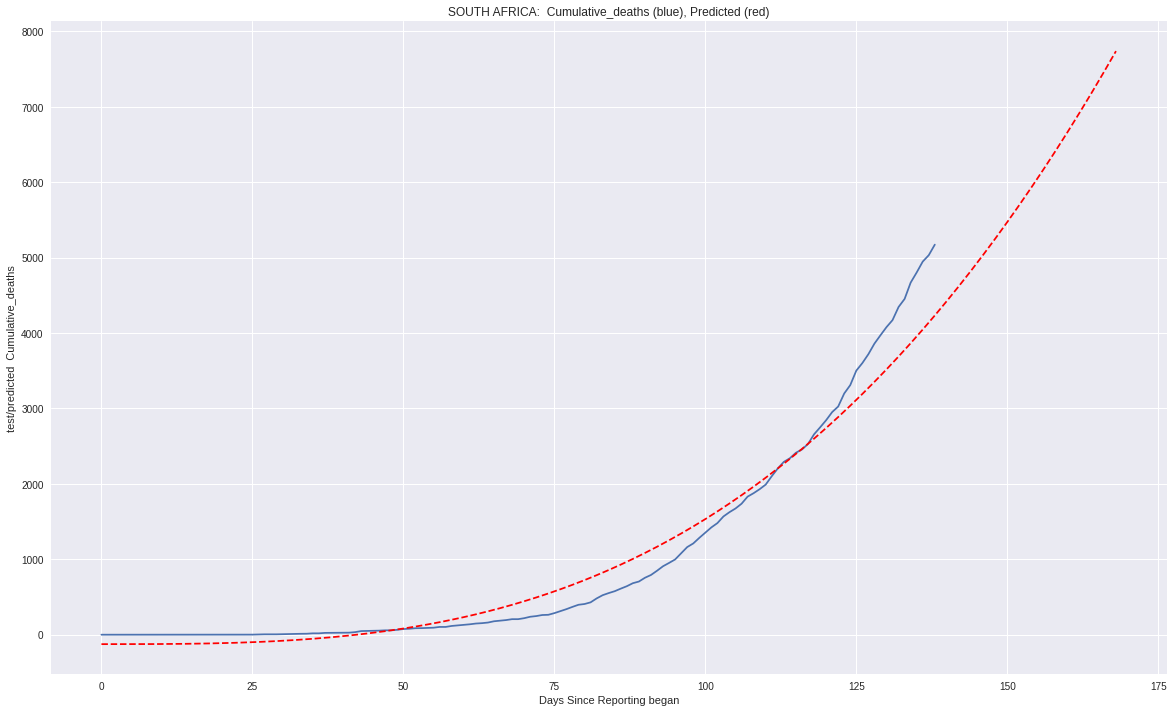

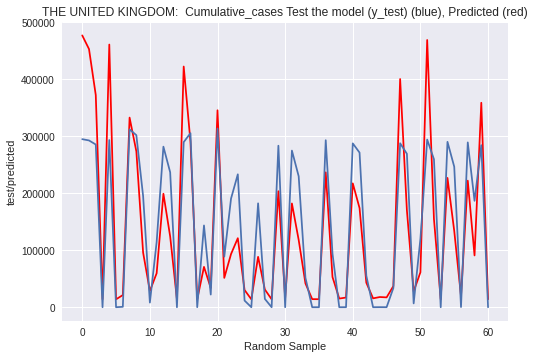

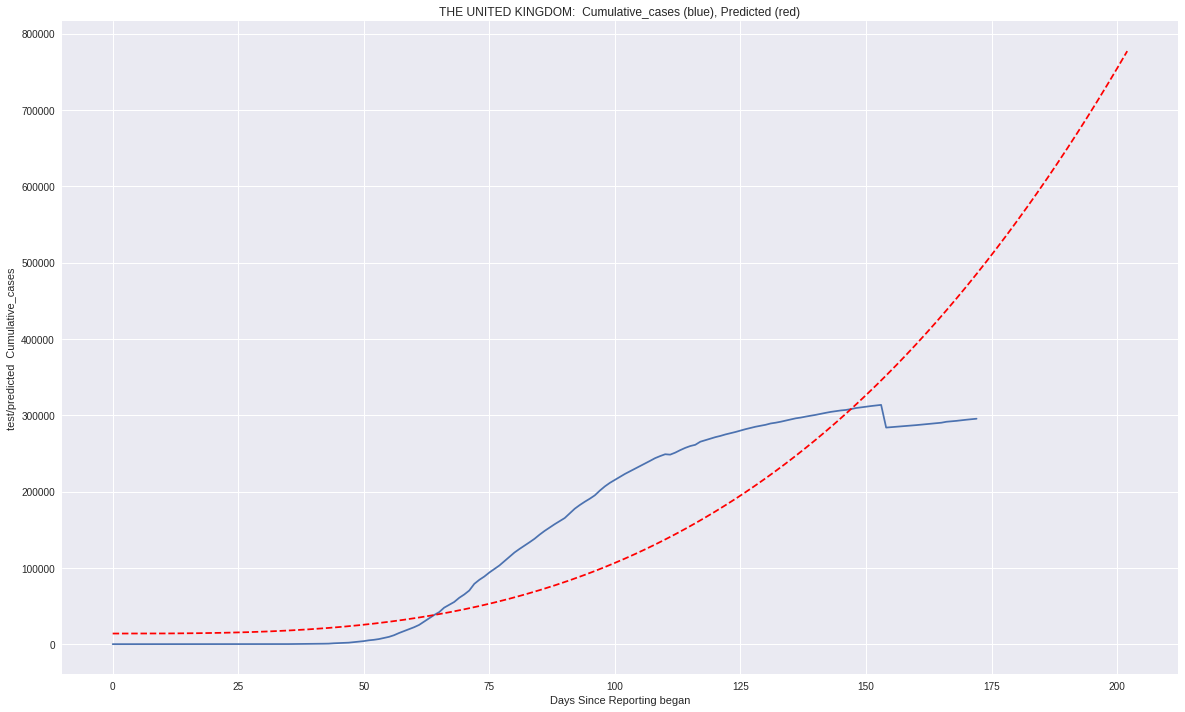

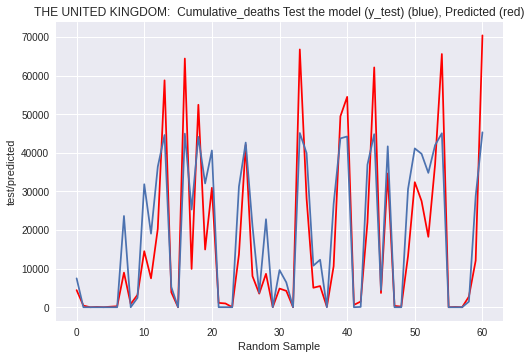

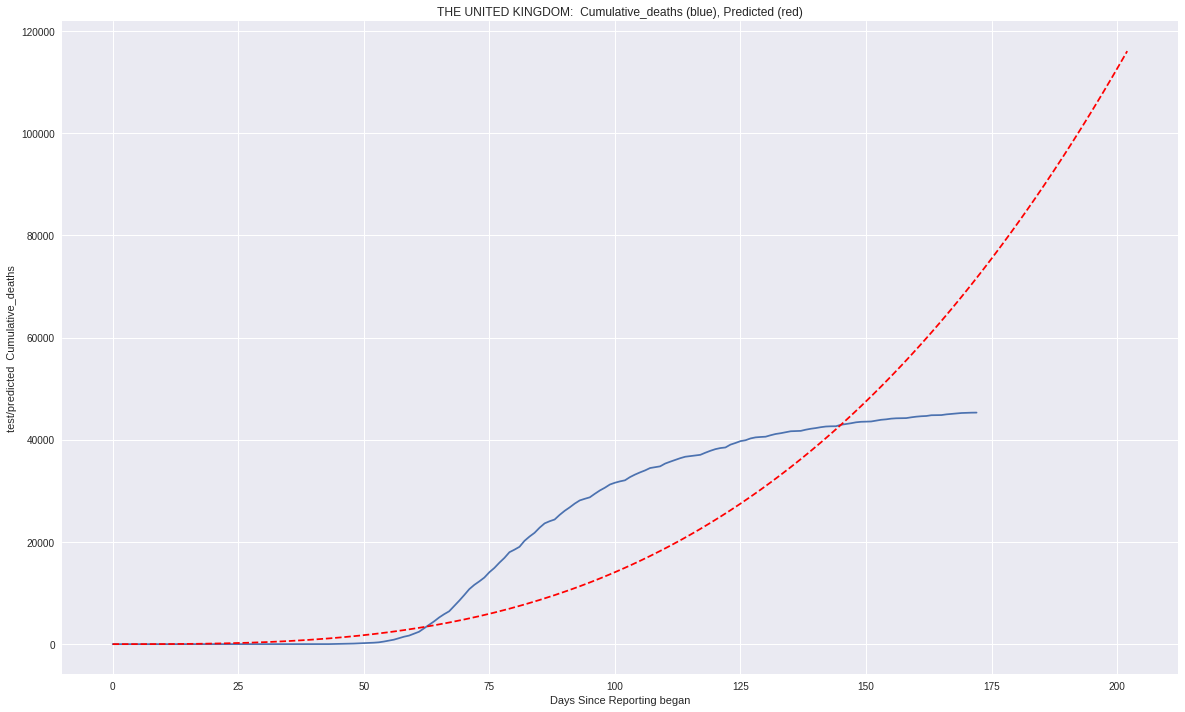

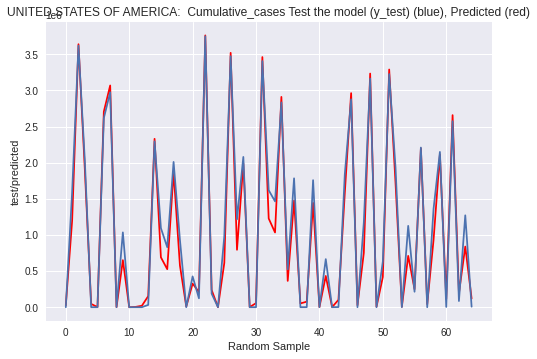

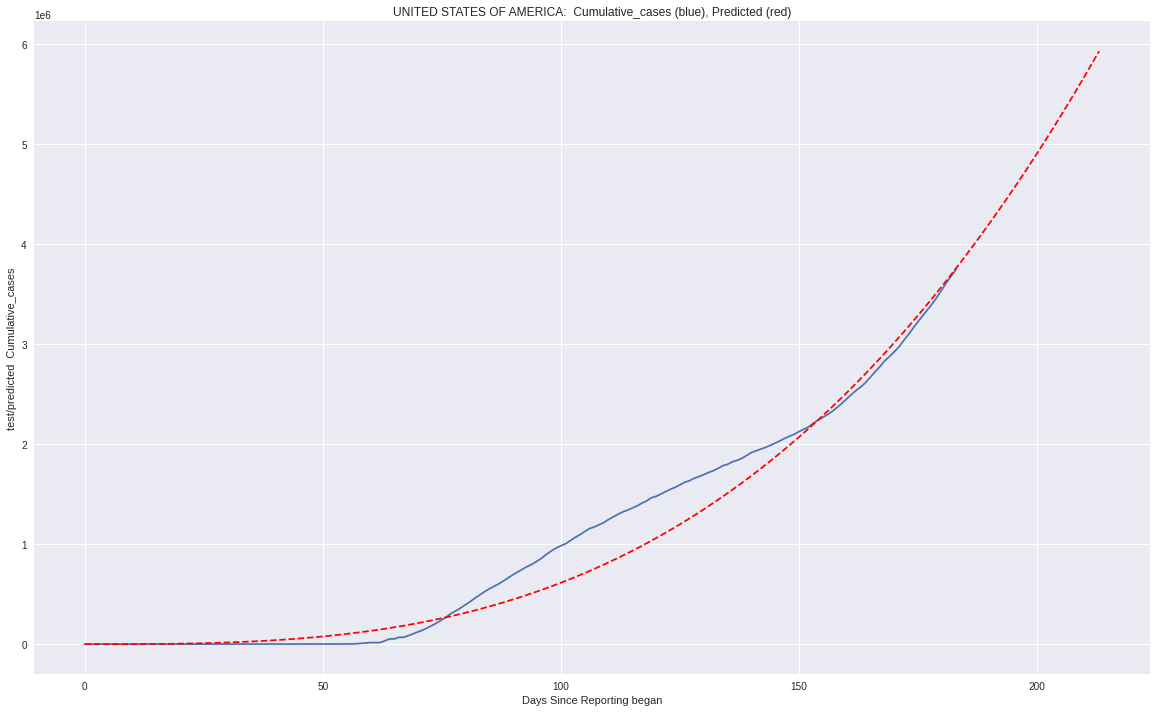

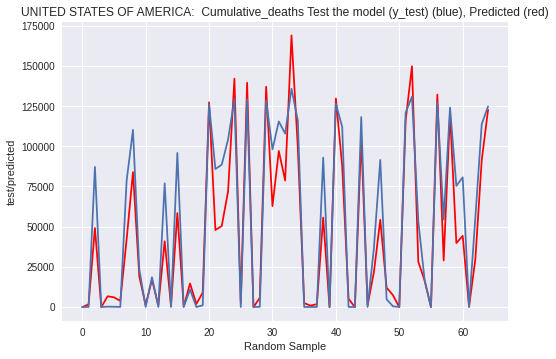

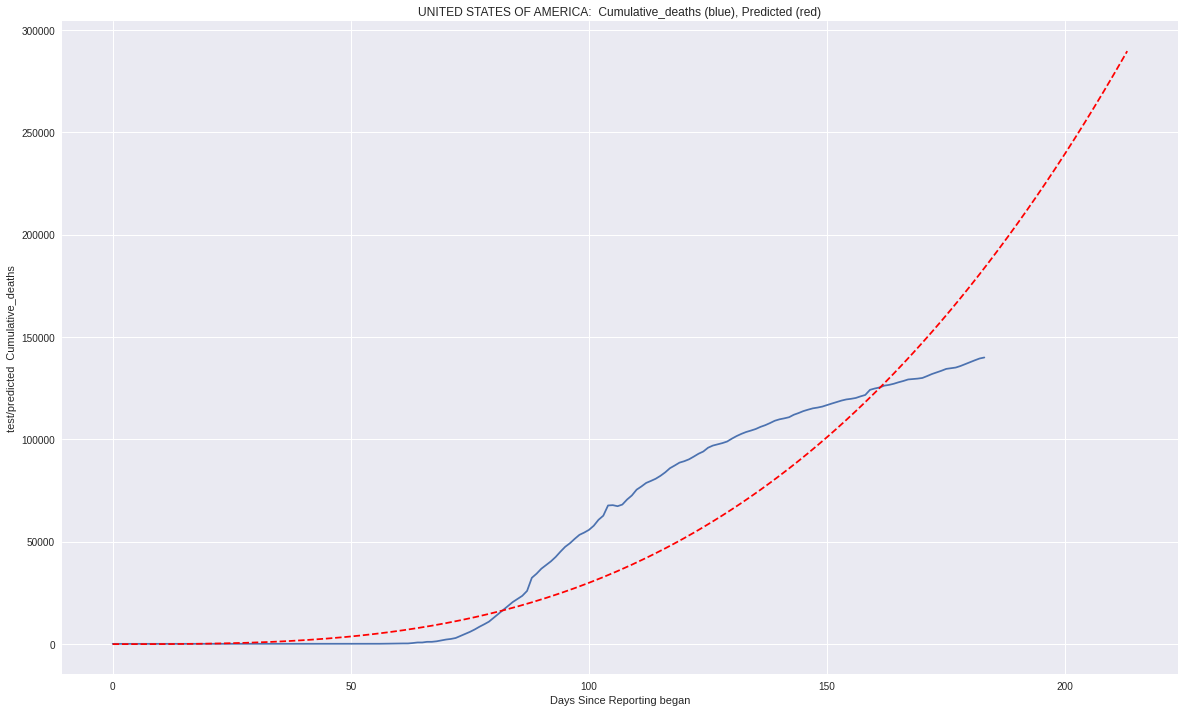

In [65]:
## LOOP THROUGH EACH COUNTRY
for country in worst_affected_countries:
    print(country)    
    df =who_data[who_data[' Country']==country].reset_index()
    df = df.drop(['index'], axis=1)
    Country = df[' Country'][0]
    Country_code =  df[' Country_code'][0]
    WHO_region = df[' WHO_region'][0]
    #add the 30 days
    df = df.append(pd.DataFrame({'Date_reported': pd.date_range(start=df['Date_reported'].iloc[-1], periods=31, freq='D', closed='right').date}))

    df = df.reset_index()
    df = df.drop(['index'], axis=1)

    df[' Country']      = Country
    df[' Country_code'] = Country_code
    df[' WHO_region']   = WHO_region
    pred_cumulative_cases   = one_country(country, ' Cumulative_cases')
    pred_cumulative_deaths  = one_country(country, ' Cumulative_deaths')

    # If we wanted to we could apply the model easily to new cases and new deaths...Future Work.
    # pred_new_cases          = one_country(country, ' New_cases')
    # pred_new_deaths         = one_country(country, ' New_deaths')
    
    df['PRED_CUMULATIVE_CASES'] = pred_cumulative_cases 
    df['PRED_CUMULATIVE_DEATHS'] = pred_cumulative_deaths 
    # df['PRED_NEW_CASES']  = pred_new_cases
    # df['PRED_NEW_DEATHS'] = pred_new_deaths


    with open('/Drive/My Drive/Colab Notebooks/COVID19/'+country+'.csv', 'w') as f:
      df.to_csv(f)
  


End of Notebook


In [46]:
worst_affected_countriesR = ['Chile']

Chile
Processing:  CHILE
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished


Country:  Chile  training score:  0.9723546524654756
Country:  Chile  test score:  0.9740347670914259
Processing:  CHILE
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.8min finished


Country:  Chile  training score:  0.958495790285796
Country:  Chile  test score:  0.9651865878172452


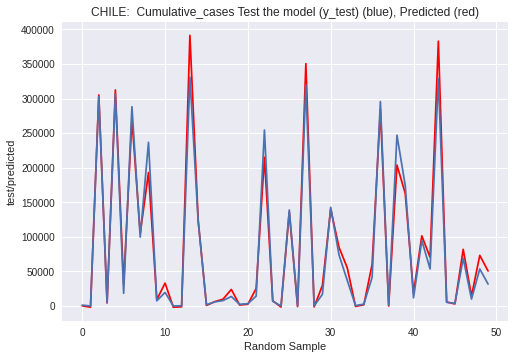

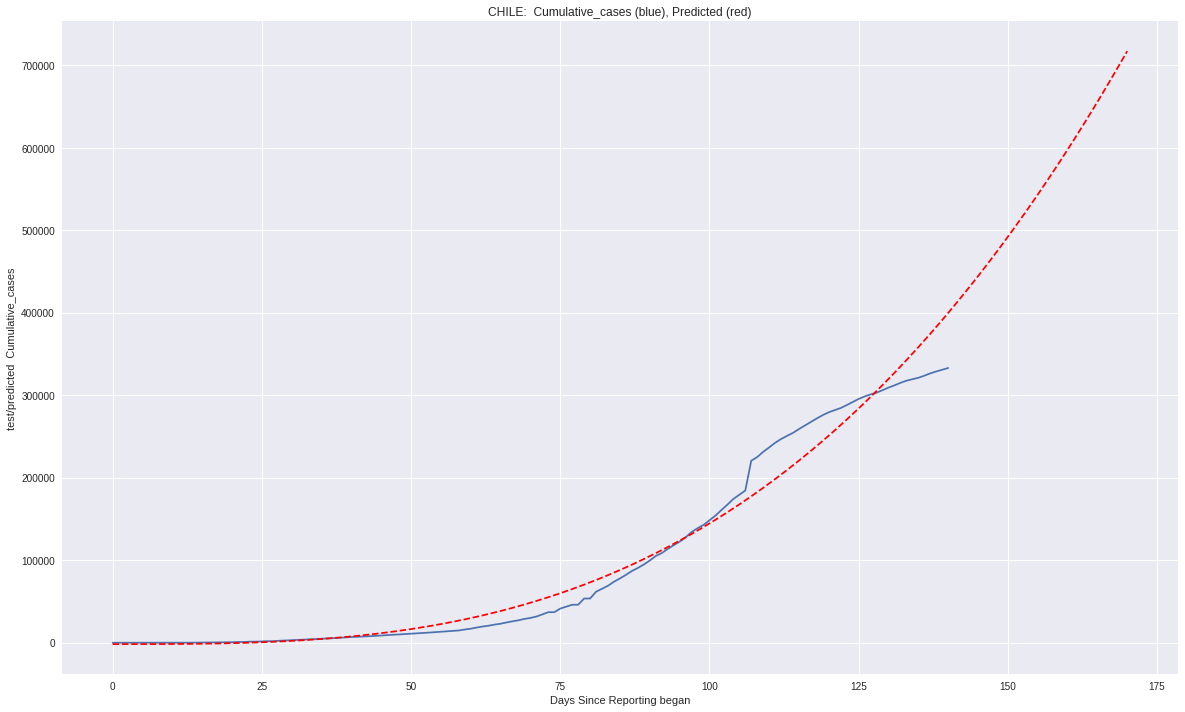

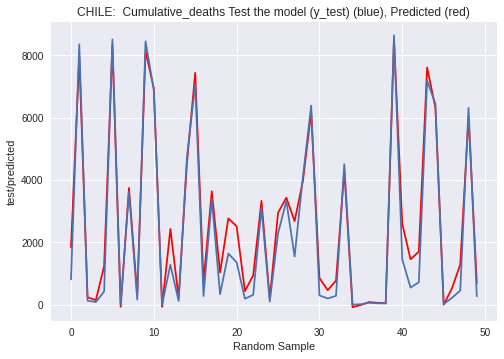

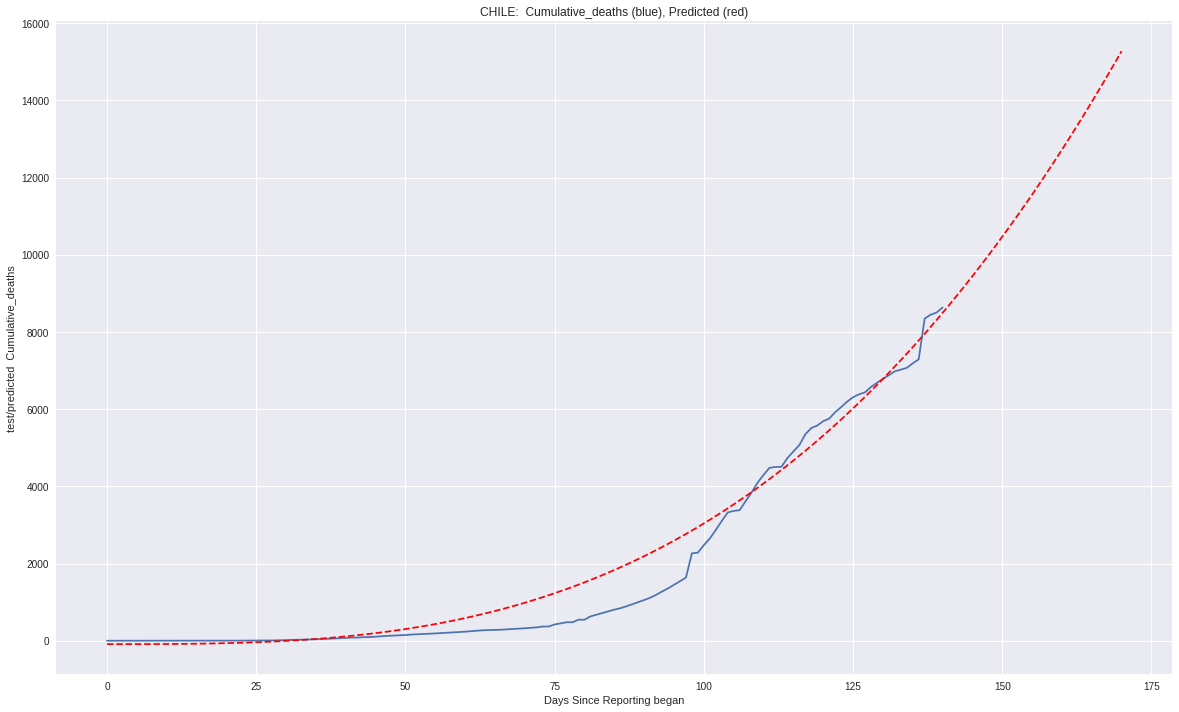

In [47]:
## LOOP THROUGH EACH COUNTRY
for country in worst_affected_countriesR:
    print(country)    
    df =who_data[who_data[' Country']==country].reset_index()
    df = df.drop(['index'], axis=1)
    Country = df[' Country'][0]
    Country_code =  df[' Country_code'][0]
    WHO_region = df[' WHO_region'][0]
    #add the 30 days
    df = df.append(pd.DataFrame({'Date_reported': pd.date_range(start=df['Date_reported'].iloc[-1], periods=31, freq='D', closed='right').date}))

    df = df.reset_index()
    df = df.drop(['index'], axis=1)

    df[' Country']      = Country
    df[' Country_code'] = Country_code
    df[' WHO_region']   = WHO_region
    pred_cumulative_cases   = one_country(country, ' Cumulative_cases')
    pred_cumulative_deaths  = one_country(country, ' Cumulative_deaths')
    # pred_new_cases          = one_country(country, ' New_cases')
    # pred_new_deaths         = one_country(country, ' New_deaths')
    
    df['PRED_CUMULATIVE_CASES'] = pred_cumulative_cases 
    df['PRED_CUMULATIVE_DEATHS'] = pred_cumulative_deaths 
    # df['PRED_NEW_CASES'] = pred_new_cases
    # df['PRED_NEW_DEATHS'] = pred_new_deaths


    with open('/Drive/My Drive/Colab Notebooks/COVID19/'+country+'.csv', 'w') as f:
      df.to_csv(f)
  


[Accuracy Table](https://github.com/annmcnamara/Project_3/blob/master/Images/accuracy2020-07-21.png
)



```
# This is formatted as code
```

This notebook follows the tutorial found here https://www.youtube.com/watch?v=sHWKN5dakPw
